In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [2]:
conn_str = os.getenv('CRAIGGER_CONN') #make sure the tunnel is open
engine = create_engine(conn_str)

In [3]:
df = pd.read_sql('''
SELECT "gAddress", "post_price", "post_date", "post_sqft", "SqftMain", "post_bedroom_count", "NumOfBeds", "quality",
"CurrentRoll_BaseYear",
"CurrentRoll_LandValue",
"CurrentRoll_ImpValue",
"CurrentRoll_LandBaseYear",
"CurrentRoll_ImpBaseYear",
"BaseValue_Land",
"BaseValue_Imp",
"BaseValue_Year",
"post_price" / "post_sqft" AS "rent_per_sqft",
("CurrentRoll_LandValue"::numeric + "CurrentRoll_ImpValue"::numeric)/"post_price" AS "assesment_to_rent_ratio",
("CurrentRoll_LandValue"::numeric + "CurrentRoll_ImpValue"::numeric)/"SqftMain"::numeric AS "assesment_per_sqft"
FROM "tax_results"
JOIN "joined_results" ON "tax_results"."gAddress" = "joined_results"."address"
WHERE "UseType" = 'Single Family Residence' AND "post_bedroom_count" = "NumOfBeds";
''', con=engine)

In [9]:
df = df[df['assesment_per_sqft']>1]
df['years_held'] = df['CurrentRoll_BaseYear'].map(int) - df['BaseValue_Year'].map(int)
df = df.drop_duplicates()
df.shape

(514, 20)

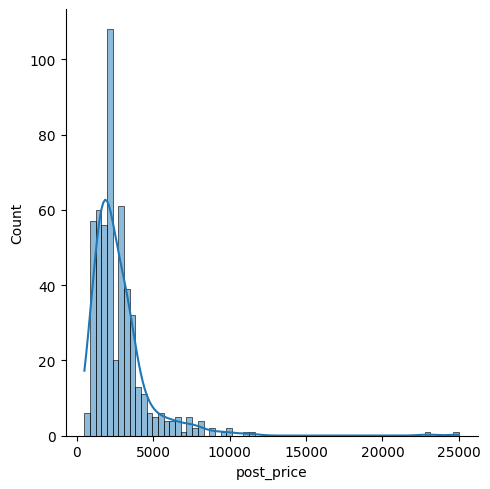

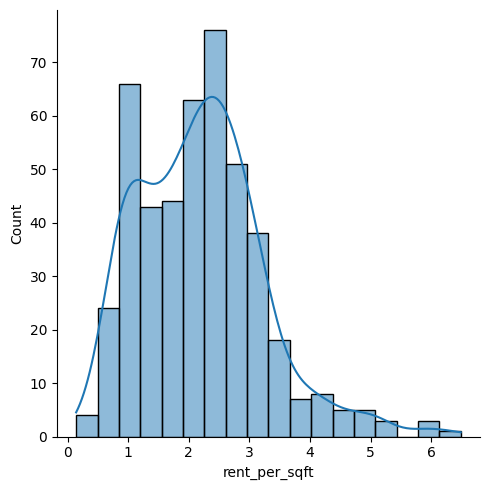

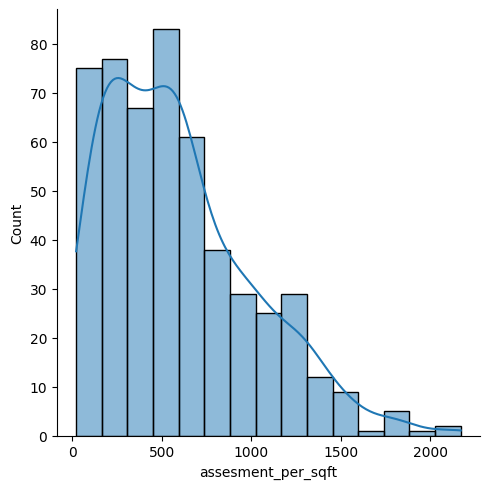

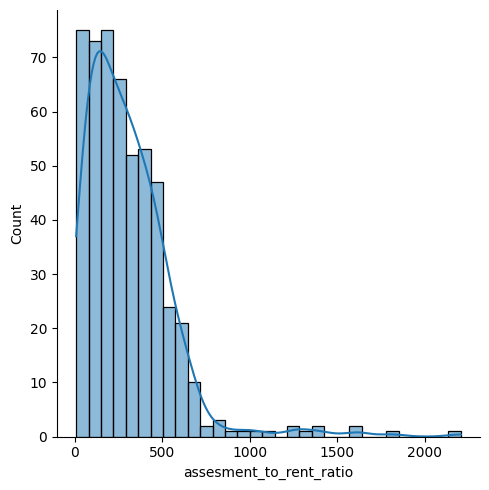

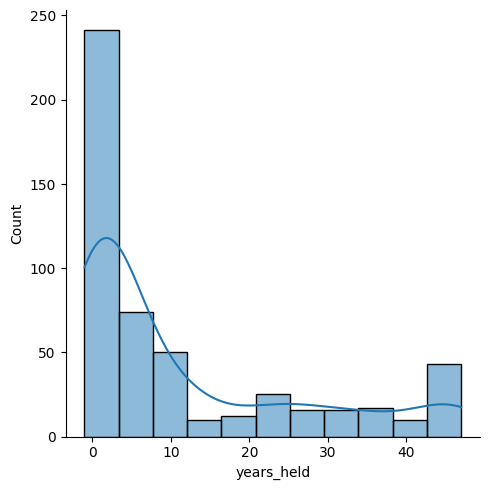

In [5]:
# loop through each column and plot a displot
for column in ['post_price', 'rent_per_sqft', 'assesment_per_sqft', 'assesment_to_rent_ratio', 'years_held']:
    sns.displot(df[column], kde=True)

Text(0.5, 1.04, 'Tax Assesment per sqft vs Rent per sqft in Los Angeles')

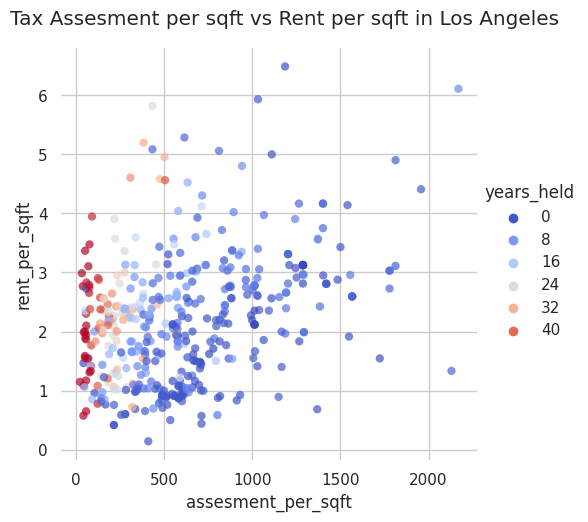

In [6]:
sns.set_theme(style="whitegrid")

cmap = sns.color_palette("coolwarm", as_cmap=True)
#cmap = sns.color_palette("flare", as_cmap=True)
#cmap = sns.color_palette("dark:salmon_r", as_cmap=True)

g = sns.relplot(
    data=df, 
    x='assesment_per_sqft', y='rent_per_sqft', hue='years_held',
    linewidth=0,
    alpha=0.7,
    palette=cmap
)
g.despine(left=True, bottom=True)
plt.suptitle("Tax Assesment per sqft vs Rent per sqft in Los Angeles", y=1.04)


In [7]:
df.sort_values(by='assesment_to_rent_ratio').head(10)

,gAddress,post_price,post_date,post_sqft,SqftMain,post_bedroom_count,NumOfBeds,quality,CurrentRoll_BaseYear,CurrentRoll_LandValue,CurrentRoll_ImpValue,CurrentRoll_LandBaseYear,CurrentRoll_ImpBaseYear,BaseValue_Land,BaseValue_Imp,BaseValue_Year,rent_per_sqft,assesment_to_rent_ratio,assesment_per_sqft,years_held
29,"1168 N Commonwealth Ave, Los Angeles, CA 90029...",3975,2021-03-19,NaN,1081,2,2,premise,2022,29311,6665,1975,1975,12700,2900,1975,NaN,9.050566,33.280296,47
186,"2510 Elsinore St, Los Angeles, CA 90026, USA",2500,2021-10-11,837.0,881,2,2,street_address,2022,17066,12445,1975,1975,7400,5400,1975,2.986858,11.804400,33.497162,47
164,"346 W Garfield Ave, Glendale, CA 91204, USA",3100,2021-10-11,1120.0,1120,2,2,premise,2022,36465,6898,1975,1975,25187,4770,1975,2.767857,13.988065,38.716964,47
144,"217 E Tichenor St, Compton, CA 90220, USA",1950,2021-10-17,1700.0,1300,3,3,premise,2022,12676,16837,1975,1975,5500,7300,1975,1.147059,15.134872,22.702308,47
821,"8838 Key St, Los Angeles, CA 90035, USA",5500,2020-10-18,1633.0,1633,3,3,premise,2022,51492,33421,1975,1975,22300,14480,1975,3.368034,15.438727,51.998163,47
668,"1021 Grevelia St, South Pasadena, CA 91030, USA",2300,2021-06-29,980.0,912,2,2,premise,2022,45129,3376,2005,2005,34365,2577,2005,2.346939,21.089130,53.185307,17
923,"12556 Everglade St, Los Angeles, CA 90066, USA",4695,2020-12-04,NaN,1432,3,3,premise,2022,70205,29081,1975,1975,30400,12600,1975,NaN,21.147178,69.333799,47
1085,"75 S San Marino Ave, Pasadena, CA 91107, USA",3395,2022-02-06,1200.0,1253,2,2,premise,2022,46151,28675,1976,1976,20388,12672,1976,2.829167,22.040059,59.717478,46
439,"8293 Grand View Dr, Los Angeles, CA 90046, USA",4170,2021-05-20,1200.0,1200,2,2,premise,2022,39472,52876,1975,1975,24947,33415,1975,3.475000,22.145803,76.956667,47
428,"12806 Hoback St, Norwalk, CA 90650, USA",2950,2021-07-08,1484.0,1484,4,4,premise,2022,18911,46849,1975,1975,10091,24976,1975,1.987871,22.291525,44.312668,47


In [8]:
df.sort_values(by='assesment_per_sqft').head(10)

,gAddress,post_price,post_date,post_sqft,SqftMain,post_bedroom_count,NumOfBeds,quality,CurrentRoll_BaseYear,CurrentRoll_LandValue,CurrentRoll_ImpValue,CurrentRoll_LandBaseYear,CurrentRoll_ImpBaseYear,BaseValue_Land,BaseValue_Imp,BaseValue_Year,rent_per_sqft,assesment_to_rent_ratio,assesment_per_sqft,years_held
144,"217 E Tichenor St, Compton, CA 90220, USA",1950,2021-10-17,1700.0,1300,3,3,premise,2022,12676,16837,1975,1975,5500,7300,1975,1.147059,15.134872,22.702308,47
29,"1168 N Commonwealth Ave, Los Angeles, CA 90029...",3975,2021-03-19,NaN,1081,2,2,premise,2022,29311,6665,1975,1975,12700,2900,1975,NaN,9.050566,33.280296,47
186,"2510 Elsinore St, Los Angeles, CA 90026, USA",2500,2021-10-11,837.0,881,2,2,street_address,2022,17066,12445,1975,1975,7400,5400,1975,2.986858,11.804400,33.497162,47
164,"346 W Garfield Ave, Glendale, CA 91204, USA",3100,2021-10-11,1120.0,1120,2,2,premise,2022,36465,6898,1975,1975,25187,4770,1975,2.767857,13.988065,38.716964,47
435,"947 Adelante Ave, Los Angeles, CA 90042, USA",1000,2021-04-18,1742.0,1742,3,3,premise,2022,22377,51262,1975,1975,10293,22200,1975,0.574053,73.639000,42.272675,47
381,"10408 Bryson Ave, South Gate, CA 90280, USA",2300,2021-12-25,1571.0,1571,2,2,premise,2022,26537,40406,1975,1975,480900,164100,2022,1.464036,29.105652,42.611712,0
428,"12806 Hoback St, Norwalk, CA 90650, USA",2950,2021-07-08,1484.0,1484,4,4,premise,2022,18911,46849,1975,1975,10091,24976,1975,1.987871,22.291525,44.312668,47
412,"14651 Helwig Ave, Norwalk, CA 90650, USA",1050,2021-08-26,972.0,972,2,2,premise,2022,19374,23756,1975,1975,8914,10300,1975,1.080247,41.076190,44.372428,47
506,"41135 161st St E, Lancaster, CA 93535, USA",1200,2021-01-20,1134.0,1134,3,3,premise,2022,10942,43784,2010,2010,9000,36000,2010,1.058201,45.605000,48.259259,12
1222,"829 Bradshawe St, Montebello, CA 90640, USA",2200,2021-03-24,1100.0,1053,3,3,premise,2022,29911,23756,1975,1975,13753,10300,1975,2.000000,24.394091,50.965812,47
